uncomment if executing in google colab

In [1]:
# ! pip uninstall pyro-ppl
# ! pip install pyro-ppl==1.5.1
# ! unzip fonts.zip 
# ! unzip claptchagen.zip
# ! unzip csis
# ! cp csis.py /usr/local/lib/python3.7/dist-packages/pyro/infer

In [2]:
import random
import string
import os
import torch.nn as nn
import torch
import torch.nn.functional as F
import pyro
import numpy as np
import pyro.optim as optim
import pyro.distributions as dist
import pyro.infer
import pyro.optim
import time

from torch.autograd import Variable
from pyro.infer import SVI, Trace_ELBO, TraceGraph_ELBO
from PIL import Image
from claptchagen.claptcha import Claptcha
from torch.distributions import constraints
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from gmade import GMADE
import matplotlib.pyplot as plt
print(pyro.__version__)
np.random.seed(0)
random.seed(0)
captcha_folder = 'generated_captchas'
captchaHeight = 24
captchaWidth = 60
captchaMarginX = 2.5
captchaMarginY = 2.5
batch_size = 10

char_dict = string.digits
#char_dict = "abc"
USE_CUDA = True
MAX_N = 4 # maximum number of letters in a captcha 
MIN_N = 2 # minimum number of letters in a captcha
MIN_NOISE = 0.003921569 # minimum noise 1./255.
MAX_NOISE = 0.8 # maximum noise
smoke_test = False
num_steps = 300 if not smoke_test else 10
TrainingSample = 3000 if not smoke_test else 100 # number of captchas generated for training 
hidden_state_dim = 128
blend_alpha_min = 0.6
blend_alpha_max = 0.99
blend_alpha = 0.6

def randomString():
    """
    return a string with <num_char> random letters
    """
    k = random.randint(MIN_N, MAX_N) # sample number of characters
    
    rndLetters = (random.choice(char_dict) for _ in range(k))
    
    pad_spaces = MAX_N - k # pad the string so the captcha is close to center
    space = " " * (pad_spaces // 2)
    return space + "".join(rndLetters) + space

def emptyString():
    """
    return a string with <num_char> random letters
    """
    #k = random.randint(MIN_N, MAX_N) # sample number of characters
    k = MAX_N
    
    rndLetters = (random.choice(char_dict) for _ in range(k))
    
    pad_spaces = MAX_N - k # pad the string so the captcha is close to center
    space = " " * (pad_spaces // 2)
    return " " * MAX_N

def ramdomNoise():
    """
    return a float between MIN_NOISE, MAX_NOISE
    """
    #return random.uniform(0.85, MAX_NOISE)
    return random.uniform(MIN_NOISE, MAX_NOISE)
def generate_noise(noise_seed):
    #return np.maximum(np.minimum(np.round(255 * ((1- noise_seed) + 0.25 * np.random.randn(captchaHeight, captchaWidth))), 255), 0)
    return np.round(255 * np.maximum(np.minimum((1- noise_seed) + 0.25 * np.random.randn(captchaHeight, captchaWidth), 1), 0))
    
def generate_random_captcha(n, save=False):
    """
    generate n random captchas,
    return a list of texts on the captchas
    """
    # Initialize Claptcha object with random text, FreeMono as font, of size
    # 100x30px, using bicubic resampling filter and adding a bit of white noise
    c = Claptcha(randomString, "fonts/FreeSans.ttf", (captchaWidth, captchaHeight), (captchaMarginX, captchaMarginY),
             resample=Image.BILINEAR, noise=0)
    captcha_generated = [ [] for i in range(MAX_N)]
    for i in range(n):
        #c2.noise = ramdomNoise()
        if save:
            text, _ = c.write(os.path.join(captcha_folder, 'captcha{}.png'.format(i)))
            os.rename(os.path.join(captcha_folder, 'captcha{}.png'.format(i)),os.path.join(captcha_folder, '{}.png'.format(text + "_" + str(i))))
        text, image = c.image
        noise_seed = ramdomNoise()
        noise_image = generate_noise(noise_seed)
        #_, noise_image = c2.image
        text = text.strip()
        image = np.array(image)[:, :, 0] # the generator is gray scale, only keep one channel is enough
        blend_alpha = random.uniform(blend_alpha_min, blend_alpha_max)
        blend_image = image * blend_alpha + (1-blend_alpha) * noise_image
        captcha_generated[len(text) - 1].append((text, image.astype(int), noise_image.astype(int), blend_image.astype(int), noise_seed, blend_alpha))
    return captcha_generated
    
captcha_generated = generate_random_captcha(TrainingSample, save=False)
for lst in captcha_generated:
    print("number of samples in group", len(lst))
    # print some sample captcha information generated
    for i, t in enumerate(lst):
        print("text", t[0], "captcha shape", t[3].shape, "noise", t[4], "blend_alpha", t[5])
        if i >= 10:
            break

1.7.0
number of samples in group 0
number of samples in group 1036
text 97 captcha shape (24, 60) noise 0.477251435734719 blend_alpha 0.8724472487003851
text 33 captcha shape (24, 60) noise 0.5815197419008579 blend_alpha 0.98486037728
text 29 captcha shape (24, 60) noise 0.3207238477743688 blend_alpha 0.6808204696326623
text 39 captcha shape (24, 60) noise 0.6744849623987603 blend_alpha 0.8273497902960264
text 02 captcha shape (24, 60) noise 0.020024701809276856 blend_alpha 0.8333371015696687
text 51 captcha shape (24, 60) noise 0.28776636960707463 blend_alpha 0.8464852302475454
text 07 captcha shape (24, 60) noise 0.20499977646135126 blend_alpha 0.7374761795806026
text 50 captcha shape (24, 60) noise 0.2642265890726464 blend_alpha 0.8312775644455194
text 18 captcha shape (24, 60) noise 0.5836103625864999 blend_alpha 0.7250616911210566
text 54 captcha shape (24, 60) noise 0.3416252606557695 blend_alpha 0.8930274749834808
text 73 captcha shape (24, 60) noise 0.42031834018553793 blend_al

text 97 noise 0.477251435734719 blend_alpha 0.8724472487003851


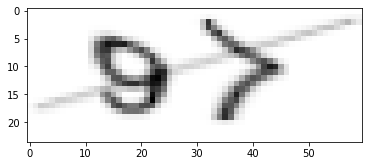

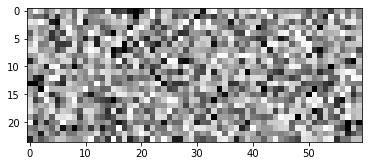

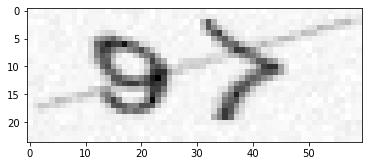

text 33 noise 0.5815197419008579 blend_alpha 0.98486037728


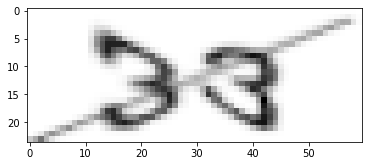

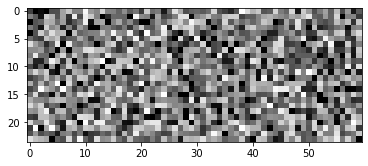

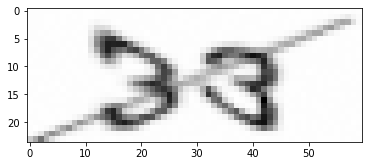

text 29 noise 0.3207238477743688 blend_alpha 0.6808204696326623


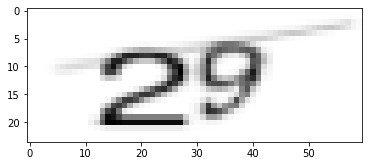

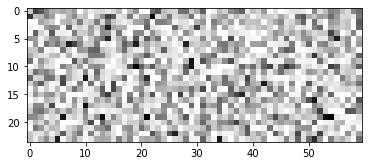

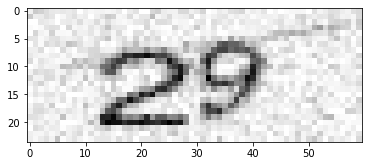

text 604 noise 0.2855672155050812 blend_alpha 0.7233167128134215


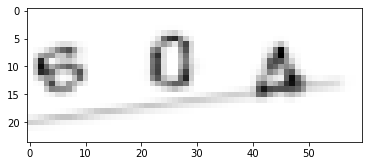

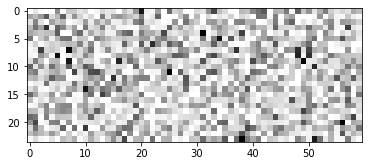

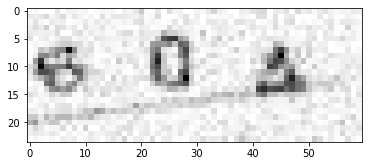

text 300 noise 0.13284971109719557 blend_alpha 0.8064949469847087


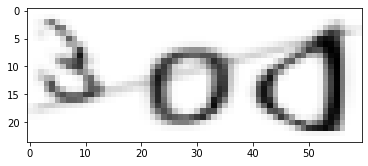

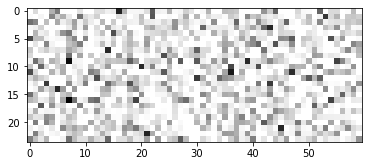

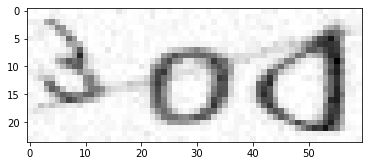

text 650 noise 0.2802029883362709 blend_alpha 0.9400268959271285


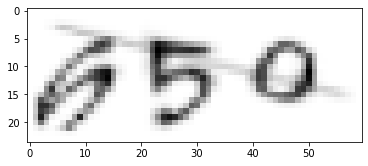

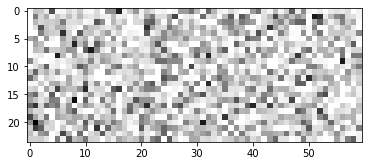

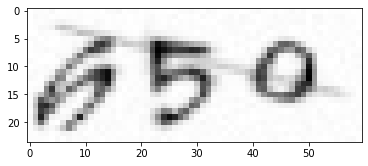

text 3877 noise 0.43972747075554175 blend_alpha 0.9176420766836211


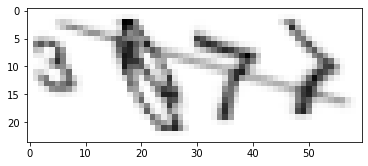

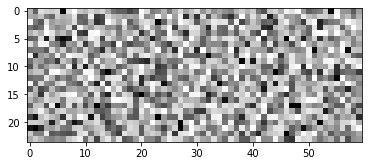

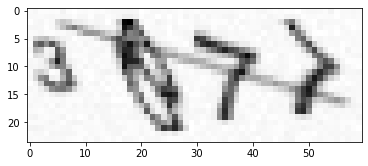

text 3989 noise 0.3961138960923285 blend_alpha 0.8500667615871172


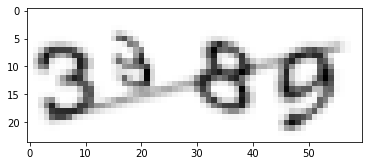

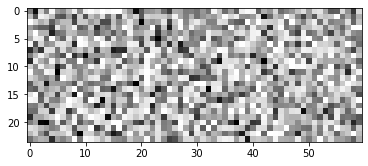

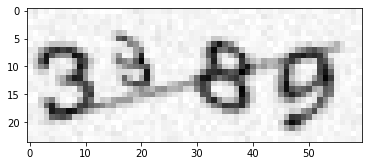

text 5159 noise 0.776668464287911 blend_alpha 0.8800641973191433


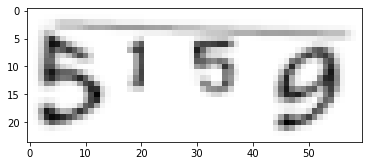

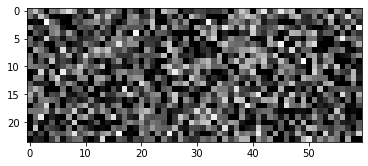

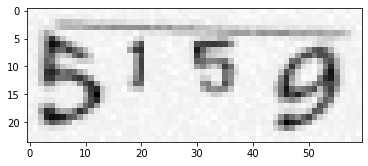

In [3]:
import sys
np.set_printoptions(threshold=sys.maxsize)
for lst in captcha_generated:
    for i in range(3):
        if len(lst) > 0:
            print("text", lst[i][0], "noise", lst[i][4], "blend_alpha", lst[i][5])
            plt.imshow(255-lst[i][1], cmap="Greys")
            plt.show()
            #print(255-lst[0][1])
            plt.imshow(255-lst[i][2], cmap="Greys")
            plt.show()
            #print(255 - lst[0][2])
            #plt.imshow(np.round((255-lst[0][2]) * blend_alpha + (255-lst[0][1]) * (1- blend_alpha)), cmap="Greys")
            plt.imshow(255-lst[i][3], cmap="Greys")
            plt.show()
            #print(np.minimum(255, (255-lst[0][2] + 255-lst[0][1])))

In [4]:
def render_image(chars, fonts="fonts/FreeSans.ttf", size=(captchaWidth, captchaHeight), 
                 margin=(captchaMarginX, captchaMarginY), resample=Image.BILINEAR, noise=0.3, use_cuda=False):
    pad_spaces = MAX_N - len(chars)
    space = " " * (pad_spaces // 2)
    chars = space + chars + space
    render = Claptcha(chars, fonts, size, margin, resample=resample, noise=noise)

    _ , rendered_image = render.image
    rendered_image = np.array(rendered_image)[:,:,0] # the generator is gray scale, only keep one channel is enough
    rendered_image = np.subtract(np.divide(rendered_image, 255), 0.5)
    rendered_image = torch.from_numpy(rendered_image)
    if use_cuda:
        rendered_image = rendered_image.cuda()
    return rendered_image

In [5]:
class CaptchaDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, raw_captchas, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.raw_captchas = raw_captchas
        self.transform = transform

    def __len__(self):
        return len(self.raw_captchas)

    def __getitem__(self, idx):
        label = self.raw_captchas[idx][0]
        char_image = self.raw_captchas[idx][1]
        noise_image = self.raw_captchas[idx][2]
        blend_image = self.raw_captchas[idx][3]
        noise = self.raw_captchas[idx][4]
        blend_alpha = self.raw_captchas[idx][5]
        
        blend_image = np.subtract(np.divide(blend_image, 255), 0.5)
        blend_image = torch.from_numpy(blend_image).float()

        if self.transform:
            blend_image = self.transform(blend_image)

        return label, blend_image, noise, blend_alpha

In [6]:
def make_loarders(BATCH_SIZE, raw_samples):
    dataloaders = [] # dataloaders for different num of char
    for lst in raw_samples:
        if lst:
            ds = CaptchaDataset(lst)
            dataloader = DataLoader(ds, batch_size=BATCH_SIZE,
                                    shuffle=True, num_workers=0, drop_last=True)
            dataloaders.append(dataloader)
    return dataloaders

def make_batches(dataloaders):
    all_batches = []
    for dl in dataloaders:
        for i_batch, sample in enumerate(dl):
            all_batches.append(sample)
    random.shuffle(all_batches)
    random.shuffle(all_batches)
    return all_batches

TrainLoaders = make_loarders(BATCH_SIZE=batch_size, raw_samples=captcha_generated)

In [7]:
class NoiseAlphaNet(nn.Module):

    def __init__(self, img_size, out_size = 1):
        """
        Network for learning noise in a captcha
        """
        super(NoiseAlphaNet, self).__init__()
        
        self.img_size = img_size
        self.fc1 = nn.Linear(img_size[0] * img_size[1], 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, out_size)
        self.softplus = nn.Softplus()
    
    def forward(self, img):
        BS = img.shape[0]
        img = img.reshape(-1, self.img_size[0] * self.img_size[1]).float()
        hidden = self.fc1(img)
        mean = self.fc3(F.relu(self.fc2(F.relu(hidden))))
        sigma = torch.tensor([[1e-8] for _ in range(BS)]).float()
        if USE_CUDA:
            sigma = sigma.cuda()
        return mean, sigma, hidden

In [8]:
# not used
class NumNet(nn.Module):
    def __init__(self, img_size, out_size = 3):
        """
        Network for learning N, number of letters in a captcha
        """
        super(NumNet, self).__init__()
        self.neural_net = nn.Sequential(
            nn.Linear(img_size[0] * img_size[1], img_size[0] * img_size[1] * 2),
            nn.ReLU(),
            nn.Linear(img_size[0] * img_size[1] * 2, 256),
            nn.ReLU(),
            nn.Linear(256, out_size),
            nn.LogSoftmax(dim=1))
  
    def forward(self, img):
        img = torch.reshape(img, (img.shape[0], img.shape[1] * img.shape[2]))
        prob = self.neural_net(img)
        return prob

In [9]:
# not used
class InputEmbedding(nn.Module):
    def __init__(self, img_size, output_size, MAX_N):
        """
        Network for letters in a captcha, given the noise and number of letters
        """
        super(InputEmbedding, self).__init__()
        self.img_size = img_size
        
        # observe layers
        self.nnfc = nn.Linear(img_size[0] * img_size[1], img_size[0] * img_size[1])
        self.conv1 = nn.Conv2d(1, 64, 3)
        self.conv2 = nn.Conv2d(64, 64, 3)
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.convBN1 = nn.BatchNorm2d(64)
        self.convBN2 = nn.BatchNorm2d(64)
        self.convBN3 = nn.BatchNorm2d(64)

    def forward(self, img, noise_map):
        
        BATCH_SIZE = img.shape[0]
        img = torch.reshape(img, (BATCH_SIZE, 1, self.img_size[0], self.img_size[1]))

        img = self.pool(F.relu(self.convBN1(self.conv1(img))))
        img = self.pool(F.relu(self.convBN2(self.conv2(img))))
        img = self.pool(F.relu(self.convBN3(self.conv3(img))))
        
        img = torch.reshape(img, (BATCH_SIZE, 1280))
        return img

In [10]:
class ChannelExtract(nn.Module):

    def __init__(self, img_size, out_size = 1):
        """
        Network for learning noise in a captcha
        """
        super(ChannelExtract, self).__init__()
        
        self.img_size = img_size
        self.fc0 = nn.Linear(img_size[0] * img_size[1] + 1, img_size[0] * img_size[1] * 2)
        self.fc1 = nn.Linear(img_size[0] * img_size[1] * 2, img_size[0] * img_size[1] * 2)
        self.fc11 = nn.Linear(img_size[0] * img_size[1] * 2, img_size[0] * img_size[1] * 2)
        self.fc2 = nn.Linear(img_size[0] * img_size[1] * 2, img_size[0] * img_size[1])
        
    def forward(self, img, alpha):
        BS = img.shape[0]
        img = img.reshape(-1, self.img_size[0] * self.img_size[1]).float()
        img = torch.cat([img, alpha], 1)
        hidden = F.relu(self.fc11(F.relu(self.fc1(F.relu(self.fc0(img))))))
        hidden = self.fc2(hidden)
        hidden = torch.reshape(hidden, (BS, self.img_size[0], self.img_size[1]))
        sigma = torch.tensor(1e-5)
        if USE_CUDA:
            sigma = sigma.cuda()
        sigma = sigma.repeat(BS, self.img_size[0], self.img_size[1])
        #print("sigma", sigma.shape)
        return hidden, sigma

In [11]:
class NoiseChannelExtract(nn.Module):

    def __init__(self, img_size, out_size = 1):
        """
        Network for learning noise in a captcha
        """
        super(NoiseChannelExtract, self).__init__()
        
        self.img_size = img_size
        self.fc0 = nn.Linear(img_size[0] * img_size[1] + 1, img_size[0] * img_size[1] * 2)
        self.fc1 = nn.Linear(img_size[0] * img_size[1] * 2, img_size[0] * img_size[1] * 2)
        self.fc11 = nn.Linear(img_size[0] * img_size[1] * 2, img_size[0] * img_size[1] * 2)
        self.fc2 = nn.Linear(img_size[0] * img_size[1] * 2, img_size[0] * img_size[1] * 2)
        
        self.fc_loc = nn.Linear(img_size[0] * img_size[1] * 2, img_size[0] * img_size[1])
        self.fc_sig = nn.Linear(img_size[0] * img_size[1] * 2, img_size[0] * img_size[1])
        self.softplus = nn.Softplus()
    
    def forward(self, img, alpha):
        BS = img.shape[0]
        img = img.reshape(-1, self.img_size[0] * self.img_size[1]).float()
        img = torch.cat([img, alpha], 1)
        hidden = F.relu(self.fc11(F.relu(self.fc1(F.relu(self.fc0(img))))))
        hidden = F.relu(self.fc2(hidden))
        loc = self.fc_loc(hidden)
        sig = self.softplus(self.fc_sig(hidden))
        loc = torch.reshape(loc, (BS, self.img_size[0], self.img_size[1]))
        sig = torch.reshape(sig, (BS, self.img_size[0], self.img_size[1])) 
        return loc, sig

In [12]:
class CharNetSingle(nn.Module):
    def __init__(self, img_size, output_size, MAX_N):
        """
        Network for letters in a captcha, given the noise and number of letters
        """
        super(CharNetSingle, self).__init__()
        self.img_size = img_size
        
        # branches
        self.pfc1 = nn.Linear(img_size[0] * img_size[1] + hidden_state_dim + 1, 2048)
        self.pfc2 = nn.Linear(2048, 1024)
        self.pfc3 = nn.Linear(1024, 1024)
        self.pfc35 = nn.Linear(1024, 1024)
        self.pfc4 = nn.Linear(1024, output_size)

    def forward(self, img, hid, noise_batch):
        
        BATCH_SIZE = img.shape[0]
        img = img.reshape(-1, self.img_size[0] * self.img_size[1]).float()
        img = torch.cat((img, hid, noise_batch), 1)
        
        out = F.relu(self.pfc1(img))
        out = F.relu(self.pfc2(out))
        out = F.relu(self.pfc3(out))
        out = F.relu(self.pfc35(out))
        out = self.pfc4(out)
        out = F.log_softmax(out, dim=1)
        
        return out

In [13]:
class simpleNN(nn.Module):
    def __init__(self, input_size=1, hidden=32, out_size=1, t="normal", out_non_linear=None):
        super().__init__()
        self.t = t
        self.out_non_linear = out_non_linear
        self.hiddeen_layer = nn.Linear(input_size, hidden)
        if t == "normal":
            self.loc_layer = nn.Linear(hidden, out_size)
            self.std_layer = nn.Linear(hidden, out_size)
            self.softplus = nn.Softplus()
        elif t == "bern":
            self.prob_layer = nn.Linear(hidden, out_size)
        elif t == "mlp":
            self.out_layer = nn.Linear(hidden, out_size)
        
    def forward(self, x_list):
        for i in range(len(x_list)):
            if x_list[i].dim() == 0:
                x_list[i] = torch.unsqueeze(x_list[i], dim=0)
        input_x = torch.cat(x_list, 1)
        #print(input_x, input_x.shape)
        hid = F.relu(self.hiddeen_layer(input_x))
        # return loc, std
        if self.t == "normal":
            return self.loc_layer(hid), self.softplus(self.std_layer(hid))
        elif self.t == "bern":
            return torch.sigmoid(self.prob_layer(hid))
        else:
            if self.out_non_linear == "tanh":
                return torch.tanh(self.out_layer(hid))
            else:
                return self.out_layer(hid)

In [14]:
def inference(t, use_cuda=False):
    """
    one epoch of inference (iterate the training set once)
    """
    start = time.time()
    loss = 0
    length = TrainingSample
    loss_group = []
    all_batches = make_batches(TrainLoaders)
    for i_batch, sample_batched in enumerate(all_batches):
        img = sample_batched[1]
        if use_cuda:
            img = img.cuda()
        IMG = {"captcha" : img}
        imme_loss = csis.step(observations=IMG)
        loss += imme_loss / length

    print("loss at epoch {} is {}".format(t, loss), end="; ")
    print("Epoch takes", round(time.time()- start), "seconds")
    return loss

In [15]:
test_accuracies = []
test_char_accuracies = []
test_noise_differences = []
test_alpha_differences = []
train_accuracies = []
train_char_accuracies = []
train_noise_differences = []
train_alpha_differences = []
def test(n = 0, use_train=False, verbose=False, use_cuda=False):
    """
    benchmarking performance on customized or training set
    """
    global test_accuracies, test_char_accuracies, test_noise_differences, test_alpha_differences
    global train_accuracies, train_char_accuracies, train_noise_differences, train_alpha_differences
    if use_train:
        TestLoaders = make_loarders(BATCH_SIZE=1, raw_samples=captcha_generated)
    else:
        test_captcha_generated = generate_random_captcha(n, save=False)
        TestLoaders = make_loarders(BATCH_SIZE=1, raw_samples=test_captcha_generated)
    
    total_correct = 0
    char_correct = 0
    total_char = 0
    all_batches = make_batches(TestLoaders)
    noise_difference = 0
    alpha_difference = 0
    for i_batch, t in enumerate(all_batches):

        label = t[0][0]
        img = t[1]
        gt_noise = t[2][0]
        gt_alpha = t[3][0]

        if use_cuda:
            img = img.cuda()
        
        IMG = {"captcha" : img}
        
        posterior = csis.run(observations=IMG)
        marginal_num = pyro.infer.EmpiricalMarginal(posterior, "num_char")
        marginal_noise = pyro.infer.EmpiricalMarginal(posterior, "noise")
        marginal_alpha = pyro.infer.EmpiricalMarginal(posterior, "alpha")
        with torch.no_grad():
            N_index = marginal_num()
            N = N_index + captchaModel.num_char_domain[0]
            noise = captchaModel._map_to_noise_range(marginal_noise()[0])
            alpha = captchaModel._map_to_alpha_range(marginal_alpha()[0])
            sampled_chars = []
            
            # sample characters one by one
            for i in range(N):
                marginal_char = pyro.infer.EmpiricalMarginal(posterior, "char_{}".format(i))()[0]
                if use_cuda:
                    marginal_char.cpu()
                sampled_chars.append(marginal_char)
        
        chars = ""
        for i in range(len(sampled_chars)):
            c = sampled_chars[i]
            chars +=  captchaModel.char_dict[c]
        correct = 0
        
        for p_char, t_char in zip(chars, label):
            if p_char == t_char:
                correct += 1
        noise_difference += abs(float(noise) - float(gt_noise))
        alpha_difference += abs(float(alpha) - float(gt_alpha))
        if not verbose:
            print("N_predicted:", int(N), "| Actual N:", len(label), "| Predicted Noise:", round(float(noise), 3), "| Actual Noise:", round(float(gt_noise), 3), "| Predicted Alpha:", round(float(alpha), 3), "| Actual Alpha:", round(float(gt_alpha), 3), "| Predicted Text:", chars, "| Actual Text:", label, "| Correct:", correct)
        if correct == len(label) and int(N) == len(label):
            total_correct += 1
        char_correct += correct
        total_char += len(label)
    num_test_samples = i_batch + 1
    accuracy = total_correct / num_test_samples
    char_accuracy = char_correct / total_char
 
    
    noise_difference = noise_difference / num_test_samples
    alpha_difference = alpha_difference / num_test_samples
    if use_train:
        train_accuracies.append(accuracy)
        train_char_accuracies.append(char_accuracy)
        train_noise_differences.append(noise_difference)
        train_alpha_differences.append(alpha_difference)
    elif n > 10:
        test_accuracies.append(accuracy)
        test_char_accuracies.append(char_accuracy)
        test_noise_differences.append(noise_difference)
        test_alpha_differences.append(alpha_difference)
    print("use_train =", use_train, "AVG Noise Difference:", noise_difference, "AVG Alpha Difference:", alpha_difference, "Total correct:", total_correct, "accuracy:{}/{}=".format(total_correct, num_test_samples), accuracy, "char_accuracy:{}/{}=".format(char_correct, total_char), char_accuracy)


In [16]:

losses  = []
def test_cycle(use_cuda):
    
    # disable dropout
#     captchaModel.numNet.eval()
#     captchaModel.charNetSingle.eval()
    test(use_train=True, verbose=True, use_cuda=use_cuda)
    test(1000, use_train=False, verbose=True, use_cuda=use_cuda)
    #test(10, use_train=True, verbose=False, use_cuda=use_cuda)
    test(10, use_train=False, verbose=False, use_cuda=use_cuda)
    # enable dropout
#     captchaModel.numNet.train()
#     captchaModel.charNetSingle.train()

def optimize(start_epoch=1, use_cuda=False):
    """
    Training/Inferencing Stage
    """
    loss_sequence = []
    pause = 5
    save_pause = 10
    print("Optimizing...")
    for t in range(start_epoch, num_steps + 1):
        L = inference(t, use_cuda)
        loss_sequence.append(L)
        losses.append(L)
        if (t % pause == 0) and (t > 0):
            test_cycle(use_cuda=use_cuda)
        #if (t % save_pause == 0) and (t > 0):
        #    save_and_download_checkpoints("branches-1-no-var-no-tanh_model.pt", "branches-1-no-var-no-tanh_optim.pt", "branches-1-no-var-no-tanh_param_store.pt")
    plt.plot(loss_sequence)
    plt.title("loss")
    plt.show()

In [17]:
# saves the model and optimizer states to disk
def save_checkpoint(currentModel, currentOptimzier, save_model, save_opt, save_param_store):
    print("saving model to %s..." % save_model)
    torch.save(currentModel.state_dict(), save_model)
    print("saving optimizer states to %s..." % save_opt)
    currentOptimzier.save(save_opt)
    print("saving pyro pram store states to %s..." % save_param_store)
    pyro.get_param_store().save(save_param_store)
    print("done saving checkpoints to disk.")

# loads the model and optimizer states from disk
def load_checkpoint(myModel, myOptimzer, load_model, load_opt, load_param_store):
    pyro.clear_param_store()
    print("loading model from %s..." % load_model)
    myModel.load_state_dict(torch.load(load_model))
    print("loading optimizer states from %s..." % load_opt)
    myOptimzer.load(load_opt)
    print("loading pyro pram store states from %s..." % load_param_store)
    pyro.get_param_store().load(load_param_store)
    print("done loading states.")
    pyro.module("guide", myModel, update_module_params=True)

def save_and_download_checkpoints(save_model, save_opt, save_param_store):
    save_checkpoint(captchaModel, optimiser, save_model, save_opt, save_param_store)
def save_metric_to_disk(file_path):
    import json
    save_dict = {
        "test_accuracies" : test_accuracies,
        "test_char_accuracies" : test_char_accuracies,
        "test_noise_differences" : test_noise_differences,
        "test_alpha_differences" : test_alpha_differences,
        "train_accuracies"  : train_accuracies,
        "train_char_accuracies"  : train_char_accuracies,
        "train_noise_differences" : train_noise_differences,
        "train_alpha_differences" : train_alpha_differences,
    }
    with open(file_path, 'w') as fout:
        json.dump(save_dict, fout)

In [18]:
class CaptchaModel(nn.Module):
    """
    network, model and guide wrapper class
    """
    def __init__(self, use_cuda=False):
        super().__init__()
        self.num_char_domain = torch.arange(MIN_N, MAX_N + 1)
        if use_cuda:
            self.num_char_domain = self.num_char_domain.cuda()
        self.numNet = NumNet((captchaHeight, captchaWidth), len(self.num_char_domain))
        self.noiseNet = NoiseAlphaNet((captchaHeight, captchaWidth), 1)
        self.alphaNet = NoiseAlphaNet((captchaHeight, captchaWidth), 1)
        self.noiseChannelExtract = NoiseChannelExtract((captchaHeight, captchaWidth))
        self.charChannelExtract = ChannelExtract((captchaHeight, captchaWidth))
        self.char_dict = char_dict # letter dictionary
        self.charNet = CharNetSingle((captchaHeight, captchaWidth), len(self.char_dict), MAX_N) # with noise
        self.noise_constraint = torch.distributions.constraints.interval(MIN_NOISE, MAX_NOISE)
        self.alpha_constraint = torch.distributions.constraints.interval(blend_alpha_min, blend_alpha_max)
        self.hid_net = simpleNN(captchaHeight * captchaWidth + hidden_state_dim + len(char_dict) + MAX_N + 1, hidden=512, out_size = hidden_state_dim, t = "mlp")
        self.h0 = nn.Parameter(torch.zeros(hidden_state_dim))
        self.noise_dim = 64
            
        if use_cuda:
            self.cuda()
        self.use_cuda = use_cuda
    
    def _map_to_noise_range(self, input):
        """
        map input number to the valid noise range
        """
        input = torch.distributions.transform_to(self.noise_constraint)(input)
        return input
    
    def _map_to_alpha_range(self, input):
        input = torch.distributions.transform_to(self.alpha_constraint)(input)
        return input

    # update from old captcha model/guide:
    # using mask to zero out index > num_char, this is a generalization of the previous version where we take the mean 
    # and assume num_char is the same for the entire batch

    def guide(self, observations={"captcha": torch.rand(1, captchaHeight, captchaWidth)}):
        pyro.module("guide", self)
        img = observations["captcha"].float()
        BS = img.shape[0]
        img_flatten = img.reshape(-1, captchaHeight * captchaWidth).float()
        
        with pyro.plate("data", img.shape[0]):
            
            prob = self.numNet(img)
            #prob = torch.mean(prob, dim=0)
            N_index = pyro.sample("num_char", dist.Categorical(prob).to_event(0))
            N_index = torch.add(N_index, self.num_char_domain[0])
            
            alpha_mean, alpha_sig, _ = self.alphaNet(img)
            alpha = pyro.sample("alpha", dist.Normal(alpha_mean, alpha_sig).to_event(1))
            
            charChannel_mean, charChannel_sig = self.charChannelExtract(img, alpha)
            charChannel = pyro.sample("char_channel", dist.Normal(charChannel_mean, charChannel_sig).to_event(2))
            noiseChannel_mean, noiseChannel_sig = self.noiseChannelExtract(img, alpha)
            noiseChannel = pyro.sample("noise_channel", dist.Normal(noiseChannel_mean, noiseChannel_sig).to_event(2))
            noise_mean, noise_sig, noise_map = self.noiseNet(noiseChannel)
            noise_batch = pyro.sample("noise", dist.Normal(noise_mean, noise_sig).to_event(1))
            #noise_batch = self._map_to_noise_range(noise_batch)
            h = self.h0.expand(BS, -1)
            
            for i in range(MAX_N):
                # tranform index to one-hot representation
                i_input = torch.tensor(i)
                if USE_CUDA:
                    i_input = i_input.cuda()
                sample_mask = i < N_index    
                i_input = F.one_hot(i_input, num_classes=MAX_N).float()
                i_input = i_input.repeat(BS, 1)
                charP_i = self.charNet(charChannel, h, noise_batch)
                c_i = pyro.sample("char_{}".format(i), dist.Categorical(charP_i).mask(sample_mask).to_event(0))
                c_i = F.one_hot(c_i, num_classes=len(self.char_dict)).float()
                # update the hidden state
                h = self.hid_net([img_flatten, h, c_i, i_input, sample_mask.float().unsqueeze(1)])

    def model_rec(self, observations={"captcha": torch.rand(1, captchaHeight, captchaWidth)}):
        
        BS = observations["captcha"].shape[0]
        
        with pyro.plate("data", BS):
            
            num_p = torch.tensor(1 / len(self.num_char_domain)).repeat(len(self.num_char_domain)).unsqueeze(0).repeat(BS, 1)
        
            if self.use_cuda:
                num_p = num_p.cuda()

            # sample the number of characters
            N_index = pyro.sample("num_char", dist.Categorical(num_p).to_event(0))
            
            N_index = torch.add(N_index,  self.num_char_domain[0])
            
            
            alpha_mean = torch.tensor((blend_alpha_min - blend_alpha_max) / 2).repeat((BS, 1))
            alpha_sig = torch.tensor(0.5).repeat((BS, 1))
            if self.use_cuda:
                alpha_mean = alpha_mean.cuda()
                alpha_sig = alpha_sig.cuda()
            alpha = pyro.sample("alpha", dist.Normal(alpha_mean, alpha_sig).to_event(1))
            alpha = self._map_to_alpha_range(alpha)
            
            noise_mean = torch.tensor((MAX_NOISE - MIN_NOISE) / 2).repeat((BS, 1))
            noise_sig = torch.tensor(0.5).repeat((BS, 1))
            if self.use_cuda:
                noise_mean = noise_mean.cuda()
                noise_sig = noise_sig.cuda()
            noise_batch = pyro.sample("noise", dist.Normal(noise_mean, noise_sig).to_event(1))
            noise_batch = self._map_to_noise_range(noise_batch)
            
            sampled_c = []
            
            def _rec(i):
                if i < MAX_N:
                    sample_mask = i < N_index
                    num_c_i = torch.tensor(1 / len(self.char_dict)).repeat((BS, len(self.char_dict)))
                    if self.use_cuda:
                        num_c_i = num_c_i.cuda()
                    c_i = pyro.sample("char_{}".format(i), dist.Categorical(num_c_i).mask(sample_mask).to_event(0))
                    sampled_c.append((sample_mask, c_i))
                    _rec(i + 1)
            _rec(0)
                
            # sample characters
            rendered_char_channels = []
            
            # does not contain any sample statements
            def _render_imgs(i):
                
                def _get_chars(j, chars, i):
                    if j < MAX_N:
                        if sampled_c[j][0][i]:
                            chars += self.char_dict[sampled_c[j][1][i]]
                            return _get_chars(j + 1, chars, i)
                    return chars
    
                if i < BS:
                    chars = _get_chars(0, "", i)
                    rendered_char_channel = render_image(chars, noise=0., use_cuda=self.use_cuda)
                    rendered_char_channels.append(rendered_char_channel)
                    _render_imgs(i + 1)
                    
            _render_imgs(0)
            
            rendered_char_channels = torch.stack(rendered_char_channels)
            noise_channel_loc = noise_batch.unsqueeze(2).repeat(1, captchaHeight, captchaWidth)
            noise_channel_sig = noise_sig.unsqueeze(2).repeat(1, captchaHeight, captchaWidth)
            sigma = torch.tensor(0.0001)
            if self.use_cuda:
                sigma = sigma.cuda()
            
            noise_channels = pyro.sample("noise_channel", dist.Normal(1 - noise_channel_loc, noise_channel_sig).to_event(2))
            char_channels = pyro.sample("char_channel", dist.Normal(rendered_char_channels, sigma).to_event(2))
            
        
        noise_channels_max = torch.ones_like(noise_channels)
        noise_channels_min = torch.zeros_like(noise_channels)
        noise_channels = torch.maximum(torch.minimum(noise_channels, noise_channels_max), noise_channels_min)
        noise_channels = noise_channels - 0.5
        
        alpha = alpha.unsqueeze(-1).repeat(1, char_channels.shape[1], char_channels.shape[2])
        blended_image = alpha  * char_channels + (1- alpha) * noise_channels
        
        sigma_obs = torch.tensor(0.000001)
        if self.use_cuda:
                sigma_obs = sigma_obs.cuda()
#         print("observations", observations["captcha"])
#         print("blended_image", blended_image)
#         print("noise_channels", noise_channels)
#         print("char_channels", char_channels)

        pyro.sample("captcha", dist.Normal(blended_image, sigma_obs).to_event(2), obs=observations["captcha"])

captchaModel = CaptchaModel(USE_CUDA)

optimiser = pyro.optim.Adam({'lr': 5e-5})
csis = pyro.infer.CSIS(captchaModel.model_rec, captchaModel.guide, optimiser, num_inference_samples=1)

optimize(1, USE_CUDA)
# test_cycle(USE_CUDA)
save_metric_to_disk("captcha_metrics_mixture_large_manual_var_n_digit_loud.json")


Optimizing...
loss at epoch 1 is 1527940126218508.5; Epoch takes 202 seconds
loss at epoch 2 is 1048635101568510.5; Epoch takes 203 seconds
loss at epoch 3 is 848247484423342.2; Epoch takes 202 seconds
loss at epoch 4 is 697070217487695.8; Epoch takes 204 seconds
loss at epoch 5 is 626716147801251.2; Epoch takes 204 seconds
use_train = True AVG Noise Difference: 0.14747639281291844 AVG Alpha Difference: 0.07668382383939644 Total correct: 108 accuracy:108/3000= 0.036 char_accuracy:2521/8950= 0.2816759776536313
use_train = False AVG Noise Difference: 0.1526617239238928 AVG Alpha Difference: 0.07547262648482342 Total correct: 49 accuracy:49/1000= 0.049 char_accuracy:842/2944= 0.2860054347826087
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.312 | Actual Noise: 0.022 | Predicted Alpha: 0.835 | Actual Alpha: 0.719 | Predicted Text: 75 | Actual Text: 78 | Correct: 1
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.587 | Actual Noise: 0.508 | Predicted Alpha: 0.729 | Actual Alpha: 0.684 |

use_train = True AVG Noise Difference: 0.12705671196458287 AVG Alpha Difference: 0.06959144042200792 Total correct: 538 accuracy:538/3000= 0.17933333333333334 char_accuracy:4748/8950= 0.5305027932960894
use_train = False AVG Noise Difference: 0.12851402986511334 AVG Alpha Difference: 0.06961152061320591 Total correct: 189 accuracy:189/1000= 0.189 char_accuracy:1603/2980= 0.5379194630872484
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.486 | Actual Noise: 0.37 | Predicted Alpha: 0.832 | Actual Alpha: 0.786 | Predicted Text: 1230 | Actual Text: 1230 | Correct: 4
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.553 | Actual Noise: 0.471 | Predicted Alpha: 0.804 | Actual Alpha: 0.748 | Predicted Text: 44 | Actual Text: 44 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.714 | Actual Noise: 0.797 | Predicted Alpha: 0.725 | Actual Alpha: 0.734 | Predicted Text: 19 | Actual Text: 60 | Correct: 0
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.604 | Actual Noise: 0.691 | P

N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.288 | Actual Noise: 0.163 | Predicted Alpha: 0.878 | Actual Alpha: 0.811 | Predicted Text: 5139 | Actual Text: 4139 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.327 | Actual Noise: 0.175 | Predicted Alpha: 0.828 | Actual Alpha: 0.631 | Predicted Text: 72 | Actual Text: 23 | Correct: 0
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.646 | Actual Noise: 0.572 | Predicted Alpha: 0.758 | Actual Alpha: 0.726 | Predicted Text: 38 | Actual Text: 38 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.314 | Actual Noise: 0.208 | Predicted Alpha: 0.848 | Actual Alpha: 0.738 | Predicted Text: 167 | Actual Text: 168 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.233 | Actual Noise: 0.029 | Predicted Alpha: 0.885 | Actual Alpha: 0.865 | Predicted Text: 2762 | Actual Text: 2463 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.466 | Actual Noise: 0.331 | Predicted Alpha: 0.83 | Actual Alpha:

N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.394 | Actual Noise: 0.261 | Predicted Alpha: 0.847 | Actual Alpha: 0.751 | Predicted Text: 6636 | Actual Text: 6536 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.638 | Actual Noise: 0.495 | Predicted Alpha: 0.716 | Actual Alpha: 0.632 | Predicted Text: 96 | Actual Text: 96 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.272 | Actual Noise: 0.171 | Predicted Alpha: 0.865 | Actual Alpha: 0.864 | Predicted Text: 72 | Actual Text: 72 | Correct: 2
use_train = False AVG Noise Difference: 0.13470095436473808 AVG Alpha Difference: 0.0511559125145221 Total correct: 6 accuracy:6/10= 0.6 char_accuracy:22/26= 0.8461538461538461
loss at epoch 51 is 252180259377449.1; Epoch takes 234 seconds
loss at epoch 52 is 246349861971039.28; Epoch takes 231 seconds
loss at epoch 53 is 249726712832693.38; Epoch takes 240 seconds
loss at epoch 54 is 238886967650246.97; Epoch takes 241 seconds
loss at epoch 55 is 241720057486069.12;

loss at epoch 66 is 222152830750884.44; Epoch takes 219 seconds
loss at epoch 67 is 213938846259630.2; Epoch takes 238 seconds
loss at epoch 68 is 208403290819666.97; Epoch takes 231 seconds
loss at epoch 69 is 207910843549211.25; Epoch takes 214 seconds
loss at epoch 70 is 209993165649875.2; Epoch takes 228 seconds
use_train = True AVG Noise Difference: 0.14532157198059192 AVG Alpha Difference: 0.06985095922045224 Total correct: 1554 accuracy:1554/3000= 0.518 char_accuracy:6959/8950= 0.7775418994413408
use_train = False AVG Noise Difference: 0.1439128829243347 AVG Alpha Difference: 0.06841082056974661 Total correct: 529 accuracy:529/1000= 0.529 char_accuracy:2362/3004= 0.7862849533954727
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.44 | Actual Noise: 0.751 | Predicted Alpha: 0.89 | Actual Alpha: 0.948 | Predicted Text: 938 | Actual Text: 998 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.723 | Actual Noise: 0.787 | Predicted Alpha: 0.885 | Actual Alpha: 0.888 | Pr

loss at epoch 85 is 193293260129423.97; Epoch takes 236 seconds
use_train = True AVG Noise Difference: 0.10748635802775969 AVG Alpha Difference: 0.06543852125503281 Total correct: 1781 accuracy:1781/3000= 0.5936666666666667 char_accuracy:7383/8950= 0.8249162011173184
use_train = False AVG Noise Difference: 0.10641847499028788 AVG Alpha Difference: 0.06371605664886659 Total correct: 561 accuracy:561/1000= 0.561 char_accuracy:2464/3036= 0.8115942028985508
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.396 | Actual Noise: 0.251 | Predicted Alpha: 0.833 | Actual Alpha: 0.729 | Predicted Text: 76 | Actual Text: 76 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.356 | Actual Noise: 0.3 | Predicted Alpha: 0.823 | Actual Alpha: 0.76 | Predicted Text: 1592 | Actual Text: 1062 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.338 | Actual Noise: 0.264 | Predicted Alpha: 0.867 | Actual Alpha: 0.816 | Predicted Text: 3697 | Actual Text: 3697 | Correct: 4
N_predicted:

use_train = False AVG Noise Difference: 0.14112488190936864 AVG Alpha Difference: 0.06496235322965585 Total correct: 607 accuracy:607/1000= 0.607 char_accuracy:2492/3002= 0.8301132578281146
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.244 | Actual Noise: 0.06 | Predicted Alpha: 0.856 | Actual Alpha: 0.68 | Predicted Text: 0055 | Actual Text: 9985 | Correct: 1
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.478 | Actual Noise: 0.456 | Predicted Alpha: 0.896 | Actual Alpha: 0.908 | Predicted Text: 946 | Actual Text: 946 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.55 | Actual Noise: 0.699 | Predicted Alpha: 0.887 | Actual Alpha: 0.924 | Predicted Text: 287 | Actual Text: 287 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.588 | Actual Noise: 0.393 | Predicted Alpha: 0.819 | Actual Alpha: 0.737 | Predicted Text: 25 | Actual Text: 26 | Correct: 1
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.441 | Actual Noise: 0.297 | Predicted Alpha: 0.761 | Ac

N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.308 | Actual Noise: 0.235 | Predicted Alpha: 0.876 | Actual Alpha: 0.831 | Predicted Text: 05 | Actual Text: 05 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.299 | Actual Noise: 0.224 | Predicted Alpha: 0.906 | Actual Alpha: 0.945 | Predicted Text: 7899 | Actual Text: 7899 | Correct: 4
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.216 | Actual Noise: 0.106 | Predicted Alpha: 0.883 | Actual Alpha: 0.8 | Predicted Text: 124 | Actual Text: 124 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.799 | Actual Noise: 0.788 | Predicted Alpha: 0.699 | Actual Alpha: 0.613 | Predicted Text: 723 | Actual Text: 323 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.446 | Actual Noise: 0.317 | Predicted Alpha: 0.85 | Actual Alpha: 0.763 | Predicted Text: 10 | Actual Text: 18 | Correct: 1
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.568 | Actual Noise: 0.444 | Predicted Alpha: 0.867 | Actual Alpha: 0.8

N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.742 | Actual Noise: 0.573 | Predicted Alpha: 0.851 | Actual Alpha: 0.811 | Predicted Text: 5582 | Actual Text: 5582 | Correct: 4
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.356 | Actual Noise: 0.157 | Predicted Alpha: 0.883 | Actual Alpha: 0.801 | Predicted Text: 32 | Actual Text: 32 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.32 | Actual Noise: 0.351 | Predicted Alpha: 0.878 | Actual Alpha: 0.9 | Predicted Text: 4744 | Actual Text: 4744 | Correct: 4
use_train = False AVG Noise Difference: 0.14468481896717142 AVG Alpha Difference: 0.08532850354374659 Total correct: 9 accuracy:9/10= 0.9 char_accuracy:30/31= 0.967741935483871
loss at epoch 131 is 154789975236894.06; Epoch takes 232 seconds
loss at epoch 132 is 152509441393825.94; Epoch takes 245 seconds
loss at epoch 133 is 151780428073105.1; Epoch takes 255 seconds
loss at epoch 134 is 151067743271079.72; Epoch takes 220 seconds
loss at epoch 135 is 1497950506070

loss at epoch 146 is 149619568244936.12; Epoch takes 218 seconds
loss at epoch 147 is 146368475101679.34; Epoch takes 177 seconds
loss at epoch 148 is 143825401437757.8; Epoch takes 198 seconds
loss at epoch 149 is 145210397482222.9; Epoch takes 200 seconds
loss at epoch 150 is 145957620251428.28; Epoch takes 197 seconds
use_train = True AVG Noise Difference: 0.13464187905157618 AVG Alpha Difference: 0.06257084155927196 Total correct: 2128 accuracy:2128/3000= 0.7093333333333334 char_accuracy:7894/8950= 0.8820111731843575
use_train = False AVG Noise Difference: 0.13446429981631758 AVG Alpha Difference: 0.059737747969447405 Total correct: 719 accuracy:719/1000= 0.719 char_accuracy:2628/2962= 0.887238352464551
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.304 | Actual Noise: 0.108 | Predicted Alpha: 0.891 | Actual Alpha: 0.887 | Predicted Text: 263 | Actual Text: 263 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.312 | Actual Noise: 0.106 | Predicted Alpha: 0.9 | Actua

loss at epoch 165 is 140232498111025.27; Epoch takes 202 seconds
use_train = True AVG Noise Difference: 0.14518409811007207 AVG Alpha Difference: 0.06823280095028916 Total correct: 1963 accuracy:1963/3000= 0.6543333333333333 char_accuracy:7652/8950= 0.8549720670391061
use_train = False AVG Noise Difference: 0.1419871560620238 AVG Alpha Difference: 0.062037938134641014 Total correct: 690 accuracy:690/1000= 0.69 char_accuracy:2605/2997= 0.8692025358692025
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.605 | Actual Noise: 0.39 | Predicted Alpha: 0.812 | Actual Alpha: 0.72 | Predicted Text: 9597 | Actual Text: 9547 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.796 | Actual Noise: 0.693 | Predicted Alpha: 0.744 | Actual Alpha: 0.673 | Predicted Text: 54 | Actual Text: 54 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.734 | Actual Noise: 0.682 | Predicted Alpha: 0.829 | Actual Alpha: 0.82 | Predicted Text: 5017 | Actual Text: 5017 | Correct: 4
N_predicted:

KeyboardInterrupt: 

In [20]:
save_metric_to_disk("captcha_metrics_mixture_large_manual_var_n_digit_loud_fix.json")

Logs